# Textractor for Large Language Models (LLM)

This example explores how using the various Textract APIs with Textractor to enrich the text given to a large language model, allowing us to process documents where some of data is not in text. 

## Installation

To begin, install the `amazon-textract-textractor` package using pip.

`pip install amazon-textract-textractor`

There are various sets of dependencies available to tailor your installation to your use case. The base package will have sensible default, but you may want to install the PDF extra dependencies if your workflow uses PDFs with `pip install amazon-textract-textractor[pdf]`. You can read more on extra dependencies [in the documentation](https://aws-samples.github.io/amazon-textract-textractor/installation.html)

## Calling Textract

In [4]:
import os
import boto3
import json

from PIL import Image
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures

def get_response_from_claude(context, prompt_data):
    body = json.dumps({
        "prompt": f"""Human: Given the following document:
        {context}
        Answer the following:\n {prompt_data}
        Assistant:""",
        "max_tokens_to_sample": 2000,
        "top_k": 1,
    })
    modelId = f'anthropic.claude-instant-v1' # change this to use a different version from the model provider
    accept = '*/*'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    answer = response_body.get('completion')

    return answer

os.environ["AWS_DEFAULT_REGION"] = "us-west-2"
os.environ["BEDROCK_ENDPOINT_URL"] = "https://bedrock-runtime.us-west-2.amazonaws.com"

bedrock = boto3.client(service_name='bedrock-runtime',region_name='us-west-2',endpoint_url='https://bedrock-runtime.us-west-2.amazonaws.com')

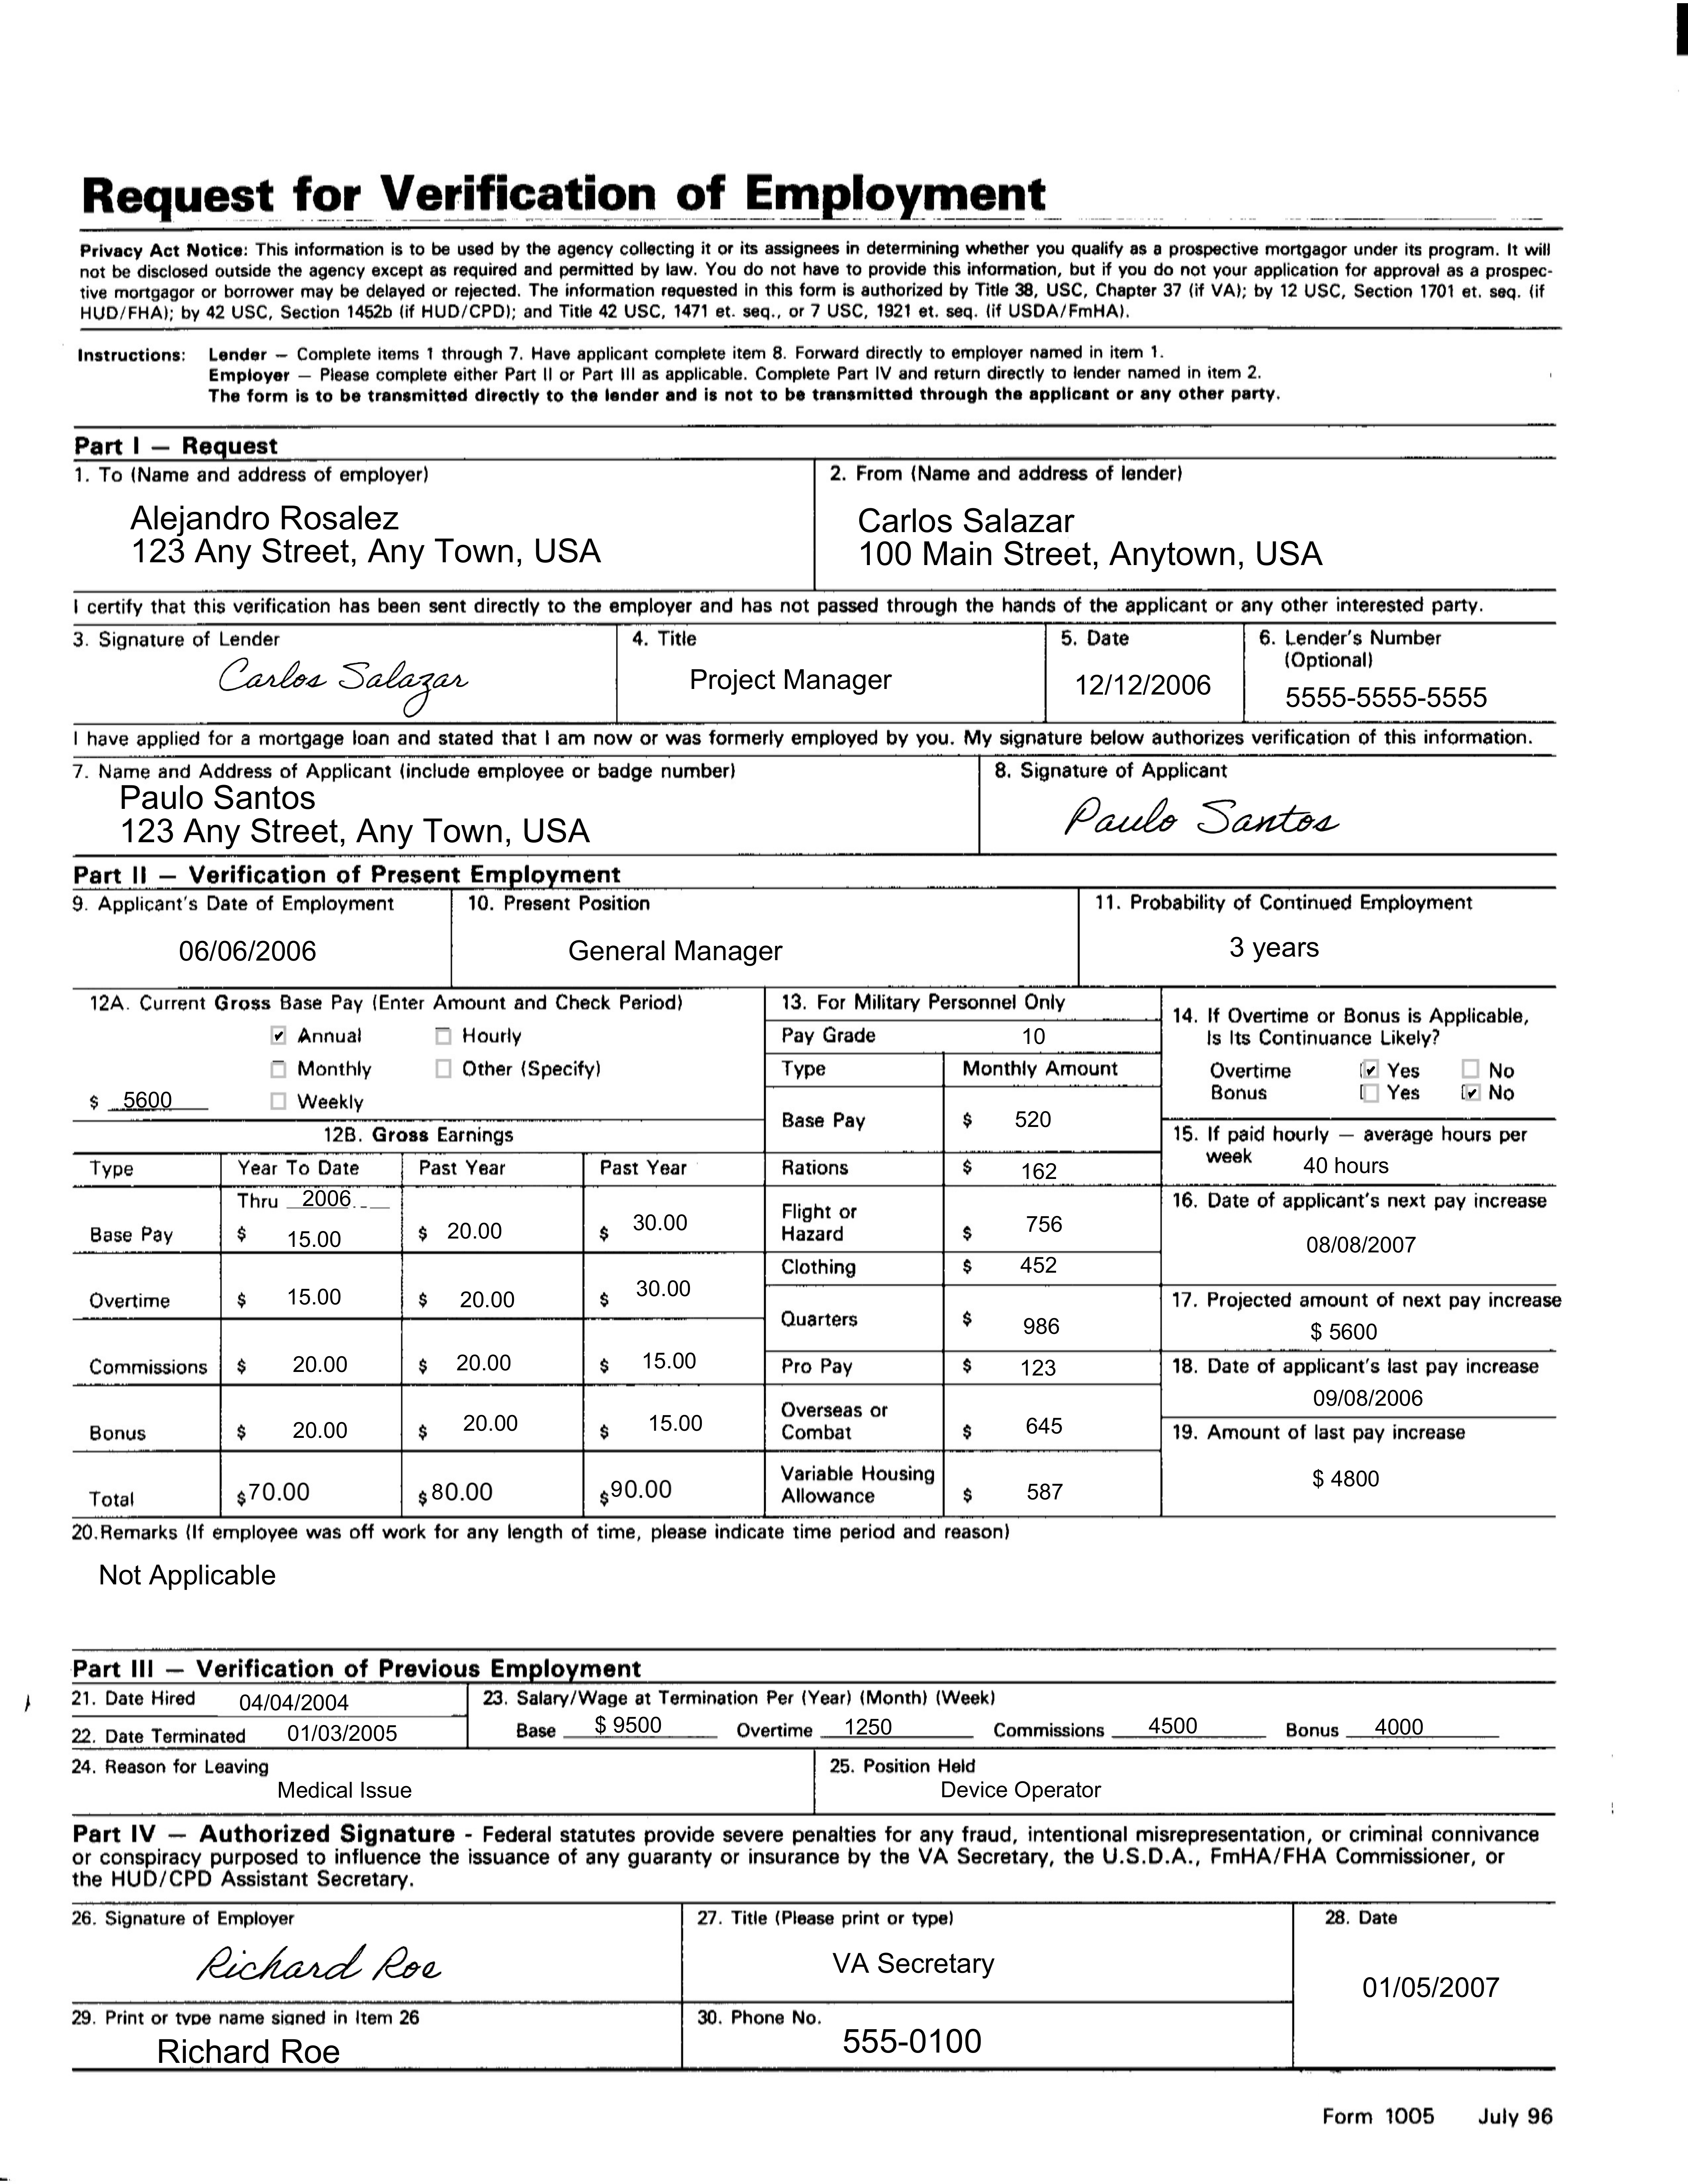

In [5]:
image = Image.open("../../../tests/fixtures/form_1005.png").convert("RGB")
image

Our example is a verification of employment form for a mortgage. This is a complex forms with over 30 fields, selection elements (checkboxes) and signatures that we want to process using Amazon Bedrock and Claude. However, LLMs only take text as input therefore we have to first convert the visual clues into textual clues. This can be done with Textractor.

In [14]:
from textractor import Textractor
from textractor.data.text_linearization_config import TextLinearizationConfig

extractor = Textractor(region_name="us-west-2")
document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.LAYOUT],
    save_image=True
)
print(document.get_text())

Request for Verification of Employment
Privacy Act Notice: This information is to be used by the agency collecting it or its assignees in determining whether you qualify as a prospective mortgagor under its program. It will not be disclosed outside the agency except as required and permitted by law. You do not have to provide this information, but if you do not your application for approval as a prospec- tive mortgagor or borrower may be delayed or rejected. The information requested in this form is authorized by Title 38, USC, Chapter 37 (if VA); by 12 USC, Section 1701 et. seq. (if HUD/FHA); by 42 USC, Section 1452b (if HUD/CPD); and Title 42 USC, 1471 et. seq., or 7 USC, 1921 et. seq. (if USDA/FmHA).
Instructions: Lender - Complete items 1 through 7. Have applicant complete item 8. Forward directly to employer named in item 1. Employer - Please complete either Part II or Part III as applicable. Complete Part IV and return directly to lender named in item 2. The form is to be transmi

As you may notice, the layout API is insufficient here. Claude agrees:

In [16]:
print(get_response_from_claude(
    document.get_text(),
    """
    - Did the applicant sign the document?
    """
))

 Based on the information provided in the document:

- No, the applicant (Paulo Santos) did not sign the document. Item 8 states "Signature of Applicant" but there is no signature filled in. The document is a "Request for Verification of Employment" form that is filled out and signed by the employer, not the applicant.


Let's instead introduce signatures as `[SIGNATURE]` token inside the resulting text.

In [22]:
document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.LAYOUT, TextractFeatures.SIGNATURES],
    save_image=True
)
print(document.get_text())

Request for Verification of Employment
Privacy Act Notice: This information is to be used by the agency collecting it or its assignees in determining whether you qualify as a prospective mortgagor under its program. It will not be disclosed outside the agency except as required and permitted by law. You do not have to provide this information, but if you do not your application for approval as a prospec- tive mortgagor or borrower may be delayed or rejected. The information requested in this form is authorized by Title 38, USC, Chapter 37 (if VA); by 12 USC, Section 1701 et. seq. (if HUD/FHA); by 42 USC, Section 1452b (if HUD/CPD); and Title 42 USC, 1471 et. seq., or 7 USC, 1921 et. seq. (if USDA/FmHA).
Instructions: Lender - Complete items 1 through 7. Have applicant complete item 8. Forward directly to employer named in item 1. Employer - Please complete either Part II or Part III as applicable. Complete Part IV and return directly to lender named in item 2. The form is to be transmi

In [23]:
print(get_response_from_claude(
    document.get_text(),
    """
    - Did the applicant sign the document?
    """
))

 Based on the information provided:

- Yes, the applicant Paulo Santos signed the document. In Part I item 7, it states "Name and Address of Applicant (include employee or badge number) Paulo Santos 123 Any Street, Any Town, USA" and there is a signature in item 8 for Paulo Santos.


Another piece of information that does not exist as text are selection items or checkboxes.

In [24]:
print(get_response_from_claude(
    document.get_text(),
    """
    - Is the reported salary annual or hourly?
    """
))

 Based on the information provided in the document:

- The reported salary in item 12A is monthly. Item 12A specifies the pay period as "Monthly".

- Item 15 also indicates the applicant is paid hourly, reporting an average of 40 hours per week. 

So in summary, the reported salary is monthly, but the applicant is paid on an hourly basis at an average of 40 hours per week.


All the above is wrong, the applicant is paid annually as checked in 12A but the model does not get that information. We can enrich the above text with selection item placeholders, namely `[X]` and `[]`. Note that those can be configured in the `TextLinearizationConfig` object.

In [29]:
# This is the default configuration
config = TextLinearizationConfig(
    selection_element_selected="[X]", 
    selection_element_not_selected="[]",
    signature_token="[SIGNATURE]",
)

document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.LAYOUT, TextractFeatures.SIGNATURES, TextractFeatures.FORMS],
    save_image=True
)
print(document.get_text(config=config))

Request for Verification of Employment
Privacy Act Notice: This information is to be used by the agency collecting it or its assignees in determining whether you qualify as a prospective mortgagor under its program. It will not be disclosed outside the agency except as required and permitted by law. You do not have to provide this information, but if you do not your application for approval as a prospec- tive mortgagor or borrower may be delayed or rejected. The information requested in this form is authorized by Title 38, USC, Chapter 37 (if VA); by 12 USC, Section 1701 et. seq. (if HUD/FHA); by 42 USC, Section 1452b (if HUD/CPD); and Title 42 USC, 1471 et. seq., or 7 USC, 1921 et. seq. (if USDA/FmHA).
Instructions: Lender - Complete items 1 through 7. Have applicant complete item 8. Forward directly to employer named in item 1. Employer - Please complete either Part II or Part III as applicable. Complete Part IV and return directly to lender named in item 2. The form is to be transmi

In [30]:
print(get_response_from_claude(
    document.get_text(),
    """
    - Is the reported salary annual or hourly?
    """
))

 Based on the information provided in the document:

- The reported salary in Part II, item 12A is annual. It specifically states the salary of $5600 is for the "Annual" period.


## Conclusion

Large-language models are only as good as their input information. By leveraging Textract APIs to enrich the text representation that is provided as input you can unblock intelligent document processing workflows without implementing complex heuristics.